In [ ]:
import kagglehub
uwrfkaggler_ravdess_emotional_speech_audio_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-speech-audio')
ejlok1_toronto_emotional_speech_set_tess_path = kagglehub.dataset_download('ejlok1/toronto-emotional-speech-set-tess')
ejlok1_cremad_path = kagglehub.dataset_download('ejlok1/cremad')
ejlok1_surrey_audiovisual_expressed_emotion_savee_path = kagglehub.dataset_download('ejlok1/surrey-audiovisual-expressed-emotion-savee')
mostafaabdlhamed_speech_signal_features_path = kagglehub.dataset_download('mostafaabdlhamed/speech-signal-features')

print('Data source import complete.')


Data source import complete.


In [ ]:
import os, shutil, pathlib, re

# In ra để biết đường dẫn thực tế mà kagglehub trả về
print(uwrfkaggler_ravdess_emotional_speech_audio_path)
print(ejlok1_toronto_emotional_speech_set_tess_path)
print(ejlok1_cremad_path)
print(ejlok1_surrey_audiovisual_expressed_emotion_savee_path)
print(mostafaabdlhamed_speech_signal_features_path)

DEST_ROOT = "/content/datasets"
os.makedirs(DEST_ROOT, exist_ok=True)

def infer_dataset_name(src_path: str) -> str:
    """
    Tạo tên gọn gàng từ đường dẫn kagglehub, ví dụ:
    /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1
      -> uwrfkaggler-ravdess-emotional-speech-audio
    """
    m = re.search(r"/datasets/([^/]+)/([^/]+)/versions/\d+", src_path)
    if m:
        return f"{m.group(1)}-{m.group(2)}"
    return pathlib.Path(src_path).name  # fallback

def copy_contents(src_dir: str, dest_dir: str):
    """
    Copy NỘI DUNG của src_dir vào dest_dir (không copy chính src_dir).
    Giữ nguyên cấu trúc con; không lỗi nếu file/dir đã tồn tại.
    """
    src = pathlib.Path(src_dir)
    dest = pathlib.Path(dest_dir)
    dest.mkdir(parents=True, exist_ok=True)

    for item in src.iterdir():
        target = dest / item.name
        if item.is_dir():
            shutil.copytree(item, target, dirs_exist_ok=True)
        else:
            # file thường
            shutil.copy2(item, target)

def move_kagglehub_dataset(src_path: str, name: str | None = None) -> str:
    if name is None:
        name = infer_dataset_name(src_path)
    dest_dir = os.path.join(DEST_ROOT, name)
    os.makedirs(dest_dir, exist_ok=True)
    copy_contents(src_path, dest_dir)
    return dest_dir

# Thực hiện copy (đặt tên thư mục đích cho dễ nhớ)
paths = [
    (uwrfkaggler_ravdess_emotional_speech_audio_path, "ravdess"),
    (ejlok1_toronto_emotional_speech_set_tess_path,   "tess"),
    (ejlok1_cremad_path,                              "cremad"),
    (ejlok1_surrey_audiovisual_expressed_emotion_savee_path, "savee"),
    (mostafaabdlhamed_speech_signal_features_path,    "speech-signal-features"),
]

final_locations = []
for p, name in paths:
    final_locations.append(move_kagglehub_dataset(p, name=name))

print("✅ Đã copy nội dung các dataset vào:")
for d in final_locations:
    print("  -", d)


In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import os, sys, warnings
import IPython.display as ipd
import librosa, librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, BatchNormalization
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

warnings.filterwarnings("ignore", category=DeprecationWarning)
print("✅ Đã import thành công tất cả thư viện!")


✅ Đã import thành công tất cả thư viện!


In [ ]:
# !apt-get update
# !apt-get install -y libsndfile1
# !pip install keras==2.10.0
# !pip install --upgrade tensorflow
# !pip install librosa==0.10.1
# !pip install "librosa==0.10.1" "matplotlib==3.7.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 109.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tf-keras 2

# Importing Data

                                              Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
#preparing data set

ravdess = "/content/datasets/ravdess/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_17', 'Actor_20', 'Actor_01', 'Actor_06', 'Actor_14', 'Actor_24', 'Actor_07', 'Actor_13', 'Actor_19', 'Actor_12', 'Actor_16', 'Actor_02', 'Actor_09', 'Actor_03', 'Actor_22', 'Actor_05', 'Actor_04', 'Actor_21', 'Actor_11', 'Actor_15', 'Actor_10', 'Actor_18', 'Actor_23', 'Actor_08']


In [ ]:
Crema = "/content/datasets/cremad/AudioWAV/"
Tess = "/content/datasets/tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/content/datasets/savee/ALL/"

# preprocessing

**Ravdees**

In [ ]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)


In [ ]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-03-01-02-02-08.wav
03
/content/datasets/ravdess/audio_speech_actors_01-24/Actor_17/03-01-05-01-01-01-17.wav
4
03-01-04-01-02-02-08.wav


In [ ]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



   Emotions                                               Path
0     angry  /content/datasets/ravdess/audio_speech_actors_...
1  surprise  /content/datasets/ravdess/audio_speech_actors_...
2  surprise  /content/datasets/ravdess/audio_speech_actors_...
3     happy  /content/datasets/ravdess/audio_speech_actors_...
4       sad  /content/datasets/ravdess/audio_speech_actors_...
______________________________________________
      Emotions                                               Path
1435     happy  /content/datasets/ravdess/audio_speech_actors_...
1436       sad  /content/datasets/ravdess/audio_speech_actors_...
1437   disgust  /content/datasets/ravdess/audio_speech_actors_...
1438  surprise  /content/datasets/ravdess/audio_speech_actors_...
1439       sad  /content/datasets/ravdess/audio_speech_actors_...
_______________________________________________
Emotions
neutral     288
surprise    192
angry       192
happy       192
sad         192
fear        192
disgust     192
Name: coun

/tmp/ipython-input-3122973769.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


**Crema DataFrame**

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
happy      1271
sad        1271
angry      1271
disgust    1271
fear       1271
neutral    1087
Name: count, dtype: int64


**TESS dataset**

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


Emotions
happy       400
sad         400
surprise    400
disgust     400
neutral     400
fear        400
angry       400
Name: count, dtype: int64


**SAVEE Dataset**

Context
The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. This is supported by the cross-cultural studies of Ekman [6] and studies of automatic emotion recognition tended to focus on recognizing these [12]. We added neutral to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences.

Content
This results in a total of 120 utterances per speaker, for example:

Common: She had your dark suit in greasy wash water all year.
Anger: Who authorized the unlimited expense account?
Disgust: Please take this dirty table cloth to the cleaners for me.
Fear: Call an ambulance for medical assistance.
Happiness: Those musicians harmonize marvelously.
Sadness: The prospect of cutting back spending is an unpleasant one for any governor.
Surprise: The carpet cleaners shampooed our oriental rug.
Neutral: The best way to learn is to solve extra problems.

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral     120
fear         60
happy        60
surprise     60
sad          60
angry        60
disgust      60
Name: count, dtype: int64


**Integration**

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,angry,/content/datasets/ravdess/audio_speech_actors_...
1,surprise,/content/datasets/ravdess/audio_speech_actors_...
2,surprise,/content/datasets/ravdess/audio_speech_actors_...
3,happy,/content/datasets/ravdess/audio_speech_actors_...
4,sad,/content/datasets/ravdess/audio_speech_actors_...


In [ ]:
print(data_path.Emotions.value_counts())


Emotions
angry       1923
happy       1923
sad         1923
disgust     1923
fear        1923
neutral     1895
surprise     652
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

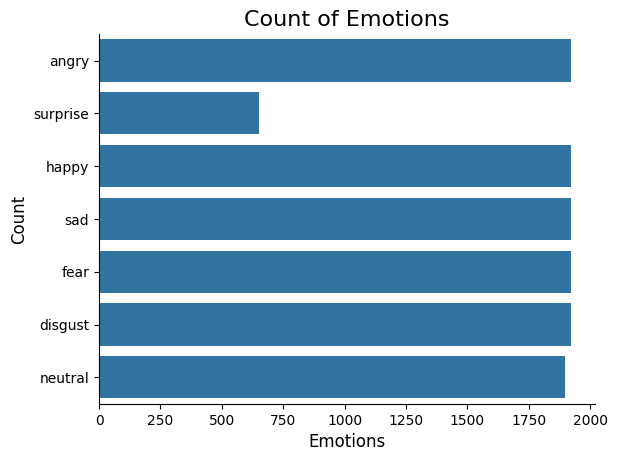

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
data,sr = librosa.load(file_path[0])
sr

22050

In [ ]:
ipd.Audio(data,rate=sr)

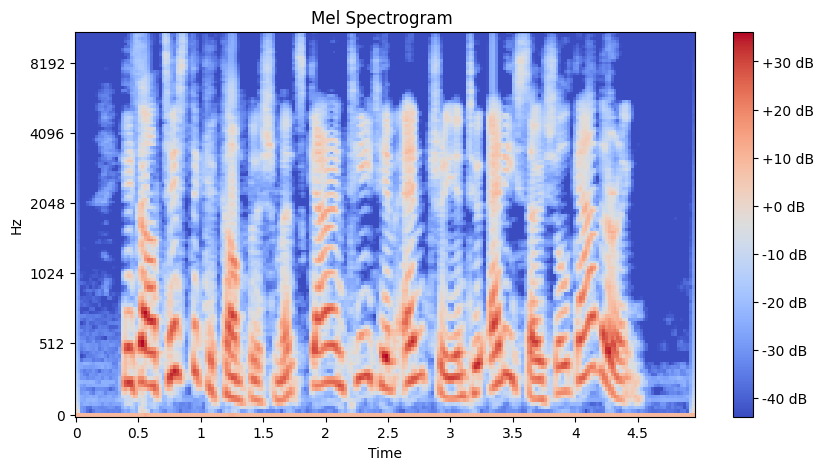

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

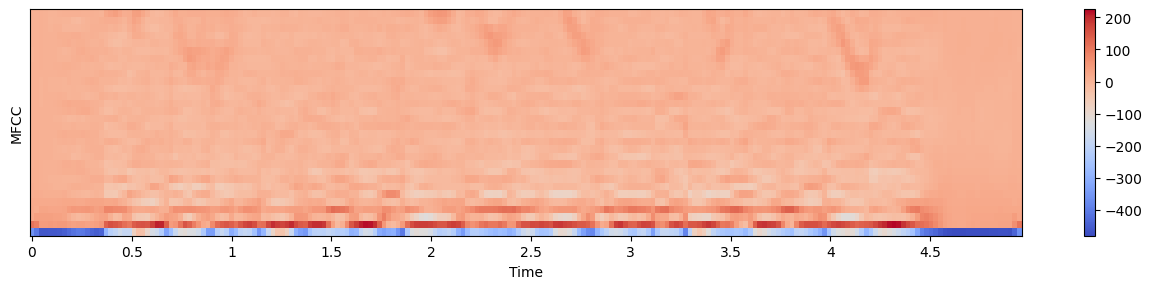

In [ ]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [ ]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    # Use the correct parameters for time_stretch.
    # librosa.effects.time_stretch takes y (audio time series) and rate as arguments.
    return librosa.effects.time_stretch(y=data, rate=rate)

# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    # Use the correct parameters for pitch_shift.
    # librosa.effects.pitch_shift takes y (audio time series) and sr (sampling rate)
    # and n_steps (pitch_factor in this case) as arguments.
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

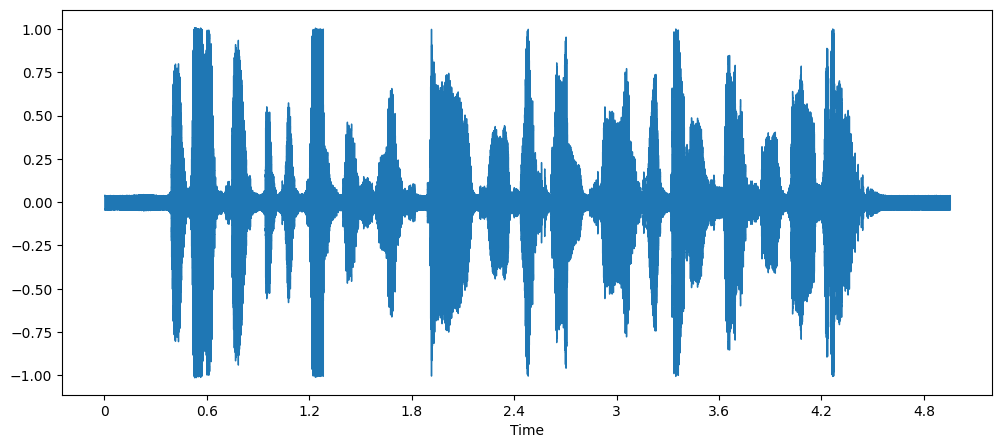

In [ ]:
# NORMAL AUDIO

import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)


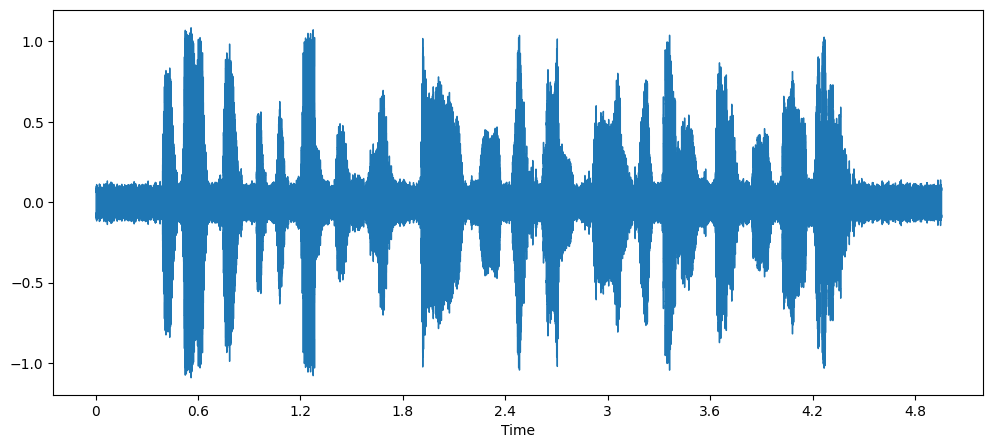

In [ ]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

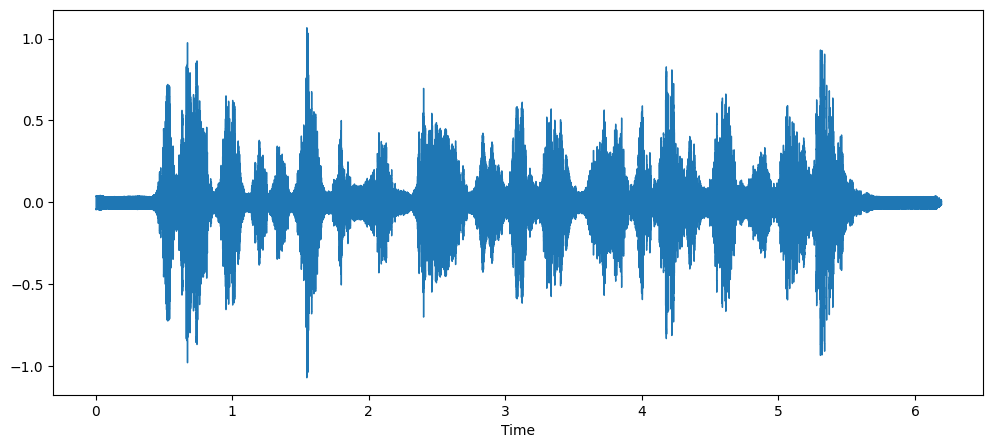

In [ ]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

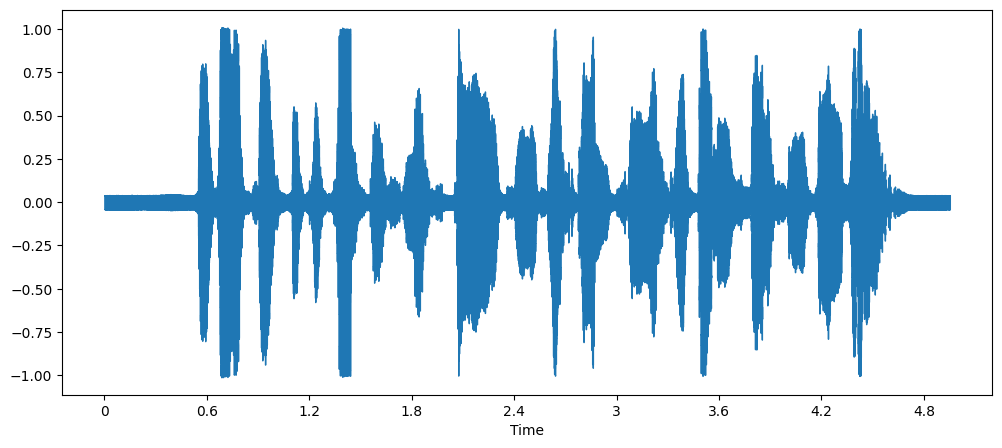

In [ ]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

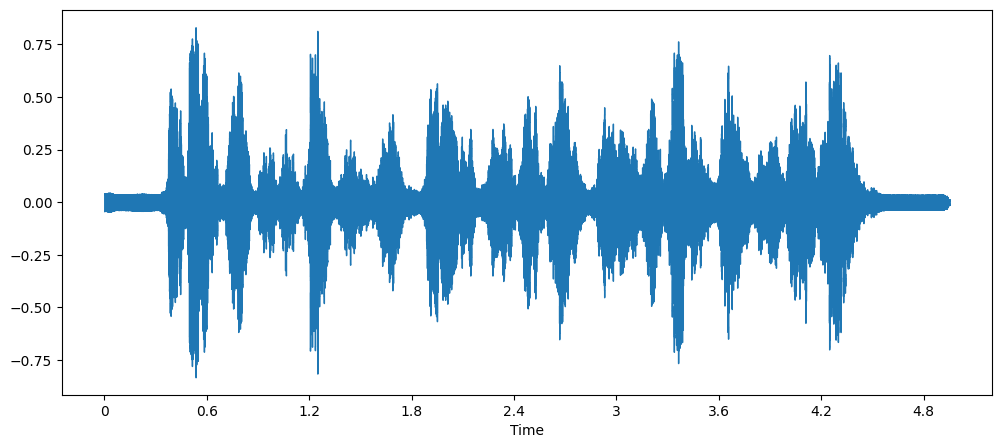

In [ ]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio

In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


# Noraml way to get features

In [ ]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:00,  3.32it/s]

0 audio has been processed


502it [01:37,  5.88it/s]

500 audio has been processed


1002it [03:12,  6.07it/s]

1000 audio has been processed


1502it [04:43,  6.97it/s]

1500 audio has been processed


2002it [05:58,  6.98it/s]

2000 audio has been processed


2502it [07:11,  7.86it/s]

2500 audio has been processed


3002it [08:25,  7.48it/s]

3000 audio has been processed


3502it [09:37,  7.04it/s]

3500 audio has been processed


4002it [10:51,  7.25it/s]

4000 audio has been processed


4502it [12:03,  6.87it/s]

4500 audio has been processed


5002it [13:16,  7.26it/s]

5000 audio has been processed


5502it [14:28,  7.34it/s]

5500 audio has been processed


6002it [15:42,  8.24it/s]

6000 audio has been processed


6502it [16:56,  5.45it/s]

6500 audio has been processed


7002it [18:09,  6.88it/s]

7000 audio has been processed


7502it [19:24,  7.65it/s]

7500 audio has been processed


8002it [20:40,  7.28it/s]

8000 audio has been processed


8502it [21:54,  7.42it/s]

8500 audio has been processed


9002it [23:07,  9.67it/s]

9000 audio has been processed


9501it [24:09,  3.77it/s]

9500 audio has been processed


10002it [25:22,  8.79it/s]

10000 audio has been processed


10502it [26:18,  9.85it/s]

10500 audio has been processed


11003it [27:09, 12.49it/s]

11000 audio has been processed


11502it [28:09,  7.99it/s]

11500 audio has been processed


12002it [29:17,  8.07it/s]

12000 audio has been processed


12162it [29:41,  6.83it/s]

Done
Time:  1781.5809934960002


# Saving features

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.141113,0.301270,0.351074,0.376953,0.305664,0.230957,0.272461,0.224609,0.242676,0.208008,...,10.284068,11.661537,7.322853,5.552678,8.496353,8.815344,5.388747,4.438804,6.162269,angry
1,0.232910,0.357422,0.477539,0.494141,0.490723,0.500977,0.506348,0.504883,0.513672,0.483887,...,1.647826,4.991649,1.051933,5.029997,8.973443,-0.105649,-6.098369,3.104405,4.987530,angry
2,0.087402,0.127930,0.139160,0.127441,0.086426,0.099609,0.115234,0.129395,0.148926,0.162598,...,10.607745,10.727929,4.509106,4.290466,8.544209,7.519253,3.610488,3.931119,5.810355,angry
3,0.244629,0.368164,0.495605,0.493652,0.507324,0.509766,0.515137,0.522949,0.516113,0.507324,...,3.125476,0.374066,-1.937065,-2.293479,-5.425976,-2.284680,-1.182575,-0.505599,-3.888400,angry
4,0.154297,0.255859,0.353027,0.381348,0.396973,0.394531,0.397949,0.397461,0.389160,0.385742,...,4.568562,4.448773,4.317296,4.170764,4.009884,3.839190,3.665780,3.497410,3.340361,surprise


In [ ]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.141113,0.301270,0.351074,0.376953,0.305664,0.230957,0.272461,0.224609,0.242676,0.208008,...,10.284068,11.661537,7.322853,5.552678,8.496353,8.815344,5.388747,4.438804,6.162269,angry
1,0.232910,0.357422,0.477539,0.494141,0.490723,0.500977,0.506348,0.504883,0.513672,0.483887,...,1.647826,4.991649,1.051933,5.029997,8.973443,-0.105649,-6.098369,3.104405,4.987530,angry
2,0.087402,0.127930,0.139160,0.127441,0.086426,0.099609,0.115234,0.129395,0.148926,0.162598,...,10.607745,10.727929,4.509106,4.290466,8.544209,7.519253,3.610488,3.931119,5.810355,angry
3,0.244629,0.368164,0.495605,0.493652,0.507324,0.509766,0.515137,0.522949,0.516113,0.507324,...,3.125476,0.374066,-1.937065,-2.293479,-5.425976,-2.284680,-1.182575,-0.505599,-3.888400,angry
4,0.154297,0.255859,0.353027,0.381348,0.396973,0.394531,0.397949,0.397461,0.389160,0.385742,...,4.568562,4.448773,4.317296,4.170764,4.009884,3.839190,3.665780,3.497410,3.340361,surprise


In [ ]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [ ]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [ ]:
np.sum(Emotions.isna())

/usr/local/lib/python3.12/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
0,0
1,0
2,0
3,0
4,0
...,...
2372,0
2373,0
2374,0
2375,0


# Data preparation

In [ ]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [ ]:
print(Y.shape)
X.shape

(48648, 7)


(48648, 2376)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [ ]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

> Applying early stopping for all models


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:
early_stop=EarlyStopping(monitor='val_accuracy',mode='max',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001, mode='max')

# CNN model

In [ ]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 2376, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 2376, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 1188, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 1188, 512)      │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1188, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 594, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 594, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 297, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 297, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 297, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 149, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 149, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,915,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,59

 Total params: 7,193,223 (27.44 MB)

 Trainable params: 7,188,871 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [ ]:
history=model.fit(x_traincnn, y_train,
                  epochs=50,
                  validation_data=(x_testcnn, y_test),
                  batch_size=64,
                  callbacks=[early_stop,
                            lr_reduction,
                            model_checkpoint
                             ]
                  )

Epoch 1/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.4078 - loss: 1.6587

609/609 ━━━━━━━━━━━━━━━━━━━━ 181s 279ms/step - accuracy: 0.4690 - loss: 1.3985 - val_accuracy: 0.5016 - val_loss: 1.2915 - learning_rate: 0.0010
Epoch 2/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5597 - loss: 1.1272

609/609 ━━━━━━━━━━━━━━━━━━━━ 161s 264ms/step - accuracy: 0.5713 - loss: 1.1028 - val_accuracy: 0.5627 - val_loss: 1.1039 - learning_rate: 0.0010
Epoch 3/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 160s 262ms/step - accuracy: 0.6226 - loss: 0.9744 - val_accuracy: 0.5359 - val_loss: 1.2155 - learning_rate: 0.0010
Epoch 4/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6287 - loss: 0.9697

609/609 ━━━━━━━━━━━━━━━━━━━━ 160s 263ms/step - accuracy: 0.6550 - loss: 0.9045 - val_accuracy: 0.6533 - val_loss: 0.9254 - learning_rate: 0.0010
Epoch 5/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.7110 - loss: 0.7649

609/609 ━━━━━━━━━━━━━━━━━━━━ 160s 262ms/step - accuracy: 0.7129 - loss: 0.7570 - val_accuracy: 0.6582 - val_loss: 0.9096 - learning_rate: 0.0010
Epoch 6/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.7417 - loss: 0.6880

609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 262ms/step - accuracy: 0.7575 - loss: 0.6532 - val_accuracy: 0.7108 - val_loss: 0.7664 - learning_rate: 0.0010
Epoch 7/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.7965 - loss: 0.5481

609/609 ━━━━━━━━━━━━━━━━━━━━ 160s 262ms/step - accuracy: 0.8143 - loss: 0.5041 - val_accuracy: 0.7774 - val_loss: 0.5976 - learning_rate: 0.0010
Epoch 8/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 261ms/step - accuracy: 0.8491 - loss: 0.4136 - val_accuracy: 0.7730 - val_loss: 0.6281 - learning_rate: 0.0010
Epoch 9/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.8586 - loss: 0.3955

609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 262ms/step - accuracy: 0.8833 - loss: 0.3282 - val_accuracy: 0.8640 - val_loss: 0.3789 - learning_rate: 0.0010
Epoch 10/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 261ms/step - accuracy: 0.9342 - loss: 0.1937 - val_accuracy: 0.8637 - val_loss: 0.3894 - learning_rate: 0.0010
Epoch 11/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9314 - loss: 0.1975

609/609 ━━━━━━━━━━━━━━━━━━━━ 160s 262ms/step - accuracy: 0.9372 - loss: 0.1822 - val_accuracy: 0.9011 - val_loss: 0.2943 - learning_rate: 0.0010
Epoch 12/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 261ms/step - accuracy: 0.9543 - loss: 0.1330 - val_accuracy: 0.8519 - val_loss: 0.4545 - learning_rate: 0.0010
Epoch 13/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9363 - loss: 0.1791

609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 262ms/step - accuracy: 0.9487 - loss: 0.1471 - val_accuracy: 0.9159 - val_loss: 0.2717 - learning_rate: 0.0010
Epoch 14/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9644 - loss: 0.1074

609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 262ms/step - accuracy: 0.9685 - loss: 0.0935 - val_accuracy: 0.9413 - val_loss: 0.1987 - learning_rate: 0.0010
Epoch 15/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 160s 262ms/step - accuracy: 0.9751 - loss: 0.0762 - val_accuracy: 0.9128 - val_loss: 0.2728 - learning_rate: 0.0010
Epoch 16/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 261ms/step - accuracy: 0.9480 - loss: 0.1499 - val_accuracy: 0.9386 - val_loss: 0.2078 - learning_rate: 0.0010
Epoch 17/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9636 - loss: 0.1062
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 261ms/step - accuracy: 0.9692 - loss: 0.0915 - val_accuracy: 0.9207 - val_loss: 0.2449 - learning_rate: 0.0010
Epoch 18/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9756 - loss: 0.0739

609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 261ms/step - accuracy: 0.9844 - loss: 0.0491 - val_accuracy: 0.9646 - val_loss: 0.1284 - learning_rate: 5.0000e-04
Epoch 19/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9850 - loss: 0.0486

609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 261ms/step - accuracy: 0.9893 - loss: 0.0364 - val_accuracy: 0.9650 - val_loss: 0.1273 - learning_rate: 5.0000e-04
Epoch 20/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9937 - loss: 0.0230

609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 262ms/step - accuracy: 0.9938 - loss: 0.0232 - val_accuracy: 0.9695 - val_loss: 0.1178 - learning_rate: 5.0000e-04
Epoch 21/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9955 - loss: 0.0194

609/609 ━━━━━━━━━━━━━━━━━━━━ 160s 262ms/step - accuracy: 0.9959 - loss: 0.0171 - val_accuracy: 0.9711 - val_loss: 0.1131 - learning_rate: 5.0000e-04
Epoch 22/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 262ms/step - accuracy: 0.9941 - loss: 0.0206 - val_accuracy: 0.9678 - val_loss: 0.1262 - learning_rate: 5.0000e-04
Epoch 23/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 261ms/step - accuracy: 0.9949 - loss: 0.0187 - val_accuracy: 0.9628 - val_loss: 0.1396 - learning_rate: 5.0000e-04
Epoch 24/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9918 - loss: 0.0257
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 261ms/step - accuracy: 0.9940 - loss: 0.0210 - val_accuracy: 0.9660 - val_loss: 0.1260 - learning_rate: 5.0000e-04
Epoch 25/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9953 - loss: 0.0175

609/609 ━━━━━━━━━━━━━━━━━━━━ 162s 266ms/step - accuracy: 0.9965 - loss: 0.0137 - val_accuracy: 0.9725 - val_loss: 0.1065 - learning_rate: 2.5000e-04
Epoch 26/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9981 - loss: 0.0076

609/609 ━━━━━━━━━━━━━━━━━━━━ 162s 265ms/step - accuracy: 0.9980 - loss: 0.0081 - val_accuracy: 0.9748 - val_loss: 0.1003 - learning_rate: 2.5000e-04
Epoch 27/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 261ms/step - accuracy: 0.9983 - loss: 0.0077 - val_accuracy: 0.9740 - val_loss: 0.1055 - learning_rate: 2.5000e-04
Epoch 28/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9971 - loss: 0.0116

609/609 ━━━━━━━━━━━━━━━━━━━━ 163s 267ms/step - accuracy: 0.9976 - loss: 0.0094 - val_accuracy: 0.9767 - val_loss: 0.0943 - learning_rate: 2.5000e-04
Epoch 29/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 261ms/step - accuracy: 0.9983 - loss: 0.0074 - val_accuracy: 0.9754 - val_loss: 0.0987 - learning_rate: 2.5000e-04
Epoch 30/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 158s 260ms/step - accuracy: 0.9978 - loss: 0.0090 - val_accuracy: 0.9761 - val_loss: 0.1051 - learning_rate: 2.5000e-04
Epoch 31/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9984 - loss: 0.0066

609/609 ━━━━━━━━━━━━━━━━━━━━ 163s 268ms/step - accuracy: 0.9986 - loss: 0.0060 - val_accuracy: 0.9769 - val_loss: 0.0989 - learning_rate: 2.5000e-04
Epoch 32/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9963 - loss: 0.0136

609/609 ━━━━━━━━━━━━━━━━━━━━ 160s 263ms/step - accuracy: 0.9968 - loss: 0.0112 - val_accuracy: 0.9773 - val_loss: 0.1020 - learning_rate: 2.5000e-04
Epoch 33/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 261ms/step - accuracy: 0.9968 - loss: 0.0117 - val_accuracy: 0.9758 - val_loss: 0.0985 - learning_rate: 2.5000e-04
Epoch 34/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9985 - loss: 0.0062

609/609 ━━━━━━━━━━━━━━━━━━━━ 164s 270ms/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 0.9785 - val_loss: 0.0917 - learning_rate: 2.5000e-04
Epoch 35/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9986 - loss: 0.0065

609/609 ━━━━━━━━━━━━━━━━━━━━ 166s 273ms/step - accuracy: 0.9986 - loss: 0.0065 - val_accuracy: 0.9802 - val_loss: 0.0945 - learning_rate: 2.5000e-04
Epoch 36/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 261ms/step - accuracy: 0.9986 - loss: 0.0057 - val_accuracy: 0.9763 - val_loss: 0.0972 - learning_rate: 2.5000e-04
Epoch 37/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 260ms/step - accuracy: 0.9977 - loss: 0.0086 - val_accuracy: 0.9781 - val_loss: 0.0898 - learning_rate: 2.5000e-04
Epoch 38/50
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9976 - loss: 0.0092
Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 261ms/step - accuracy: 0.9979 - loss: 0.0075 - val_accuracy: 0.9778 - val_loss: 0.0913 - learning_rate: 2.5000e-04
Epoch 39/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 261ms/step - accuracy: 0.9991 - loss: 0.0044 - val_accuracy: 0.9792 - val_loss: 0.0886 - learning_rate: 1.2500e-04
Epoch 40/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 159s 260ms/s

305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9802 - loss: 0.0945
Accuracy of our model on test data :  98.01644682884216 %


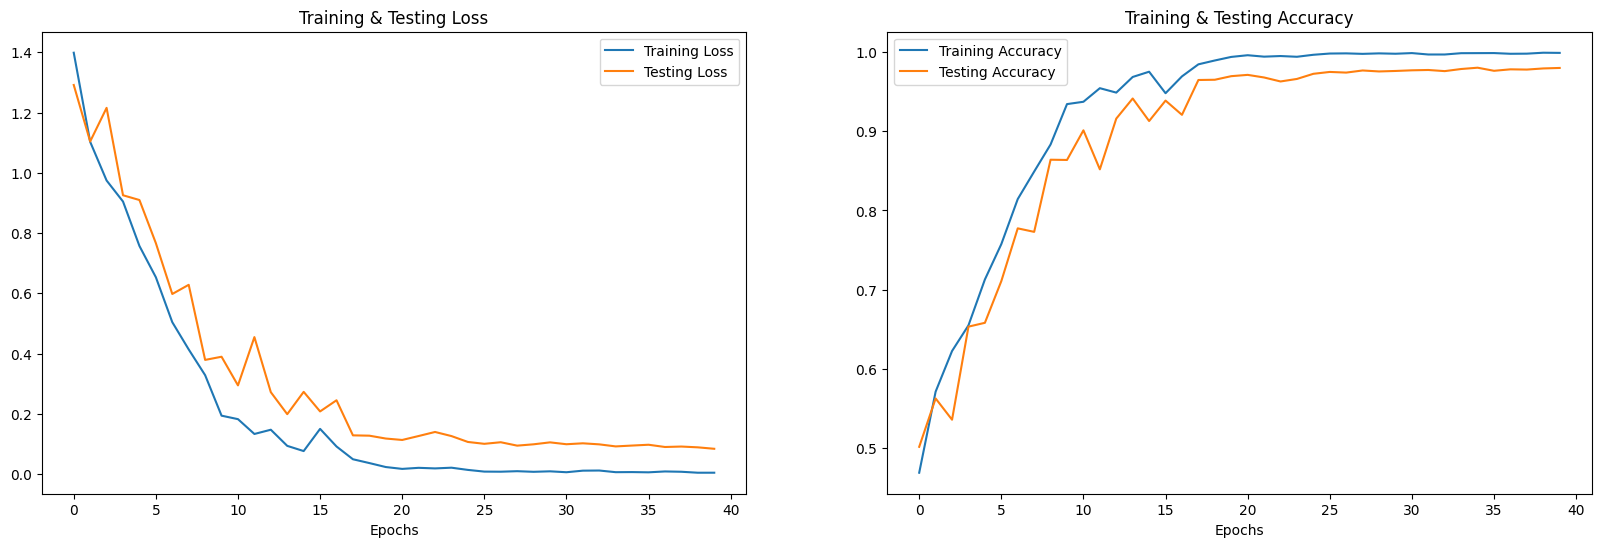

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(len(history.history['accuracy']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step


,Predicted Labels,Actual Labels
0,disgust,disgust
1,happy,happy
2,angry,angry
3,happy,happy
4,fear,fear
5,sad,sad
6,sad,sad
7,disgust,disgust
8,happy,happy
9,fear,fear


In [ ]:
df0

,Predicted Labels,Actual Labels
0,disgust,disgust
1,happy,happy
2,angry,angry
3,happy,happy
4,fear,fear
...,...,...
9725,happy,happy
9726,fear,fear
9727,neutral,neutral
9728,neutral,neutral


Some plots of multi_model
______________________________________________


# Evalutation

Results of best model

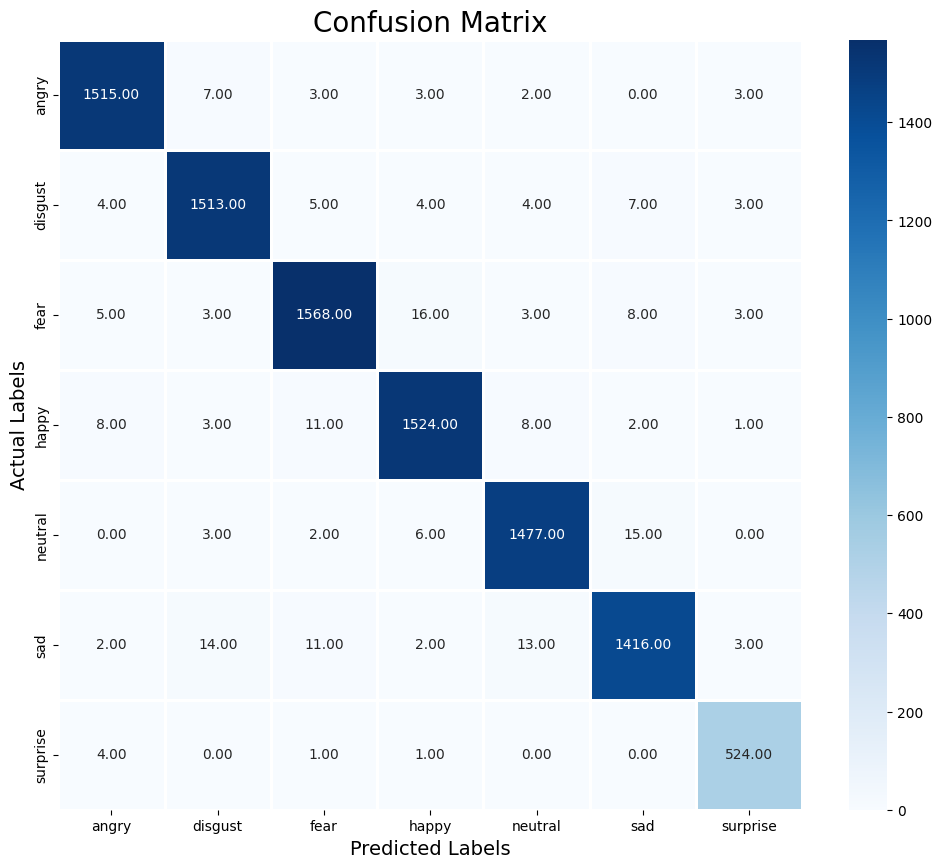

              precision    recall  f1-score   support

       angry       0.99      0.99      0.99      1533
     disgust       0.98      0.98      0.98      1540
        fear       0.98      0.98      0.98      1606
       happy       0.98      0.98      0.98      1557
     neutral       0.98      0.98      0.98      1503
         sad       0.98      0.97      0.97      1461
    surprise       0.98      0.99      0.98       530

    accuracy                           0.98      9730
   macro avg       0.98      0.98      0.98      9730
weighted avg       0.98      0.98      0.98      9730



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Saving Best Model

In [ ]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [3]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/content/drive/MyDrive/Graduation_Project/Models_output/audio_emotion/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Graduation_Project/Models_output/audio_emotion/best_model1_weights.h5")
print("Loaded model done")

Loaded model done


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.9802 - loss: 0.0945
compile_metrics: 98.02%


# Saving and Loading our Stnadrad Scaler and encoder
* To save the StandardScaler object to use it later in a Flask API

pickle file


In [ ]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

Done


# Test script
* That can predict new record

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/content/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [21]:
import pickle

with open('/content/drive/MyDrive/Graduation_Project/Models_output/audio_emotion/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

with open('/content/drive/MyDrive/Graduation_Project/Models_output/audio_emotion/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

print("Done")

Done


In [7]:
import librosa

In [11]:
import librosa
import numpy as np

def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [18]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d)
    result=np.array(res)

    # Pad or truncate the features to match the expected size (2376)
    expected_size = 2376
    if result.shape[0] < expected_size:
        # Pad with zeros if the size is smaller
        result = np.pad(result, (0, expected_size - result.shape[0]), 'constant')
    elif result.shape[0] > expected_size:
        # Truncate if the size is larger
        result = result[:expected_size]

    result=np.reshape(result,newshape=(1,expected_size))
    i_result = scaler2.transform(result)
    final_result=np.expand_dims(i_result, axis=2)

    return final_result

In [9]:
res=get_predict_feat("/content/datasets/tess/TESS Toronto emotional speech set data/OAF_Fear/OAF_back_fear.wav")
print(res.shape)

/tmp/ipython-input-2133567853.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/content/datasets/tess/TESS Toronto emotional speech set data/OAF_Fear/OAF_back_fear.wav'

In [27]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)

    # Get the predicted emotion label
    y_pred = encoder2.inverse_transform(predictions)
    predicted_emotion = y_pred[0][0]

    # Get the confidence scores for all emotions
    confidence_scores = {}
    emotion_labels = encoder2.categories_[0]
    for i, emotion in enumerate(emotion_labels):
        confidence_scores[emotion] = predictions[0][i]

    return predicted_emotion, confidence_scores

In [28]:
prediction("/content/tucgian.weba")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/tmp/ipython-input-2133567853.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


('angry',
 {'angry': np.float32(0.92920005),
  'disgust': np.float32(0.070421875),
  'fear': np.float32(4.2465548e-05),
  'happy': np.float32(0.00033248615),
  'neutral': np.float32(2.995266e-06),
  'sad': np.float32(1.1559474e-11),
  'surprise': np.float32(7.5831885e-08)})

In [29]:
prediction("/content/sohai.weba")

/tmp/ipython-input-2133567853.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


('angry',
 {'angry': np.float32(0.8789196),
  'disgust': np.float32(0.010716146),
  'fear': np.float32(0.09706148),
  'happy': np.float32(4.7658664e-06),
  'neutral': np.float32(0.0007670921),
  'sad': np.float32(0.012439176),
  'surprise': np.float32(9.1912974e-05)})

In [30]:
prediction("/content/tucgian.weba")

/tmp/ipython-input-2133567853.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


('angry',
 {'angry': np.float32(0.92920005),
  'disgust': np.float32(0.070421875),
  'fear': np.float32(4.2465548e-05),
  'happy': np.float32(0.00033248615),
  'neutral': np.float32(2.995266e-06),
  'sad': np.float32(1.1559474e-11),
  'surprise': np.float32(7.5831885e-08)})

In [ ]:
prediction("/content/vui.weba")

/tmp/ipython-input-2133567853.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
disgust


In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-08-01-01-01-01.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")